In [72]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

## Load and visualize data

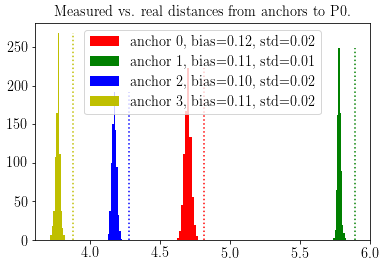

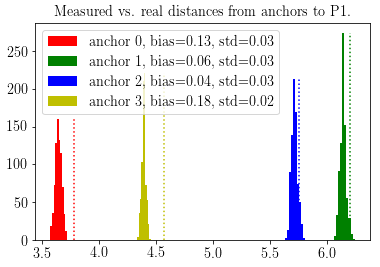

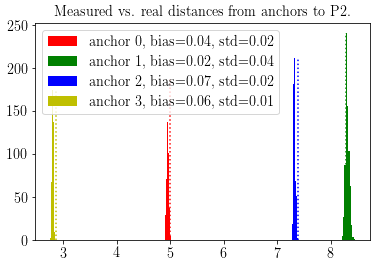

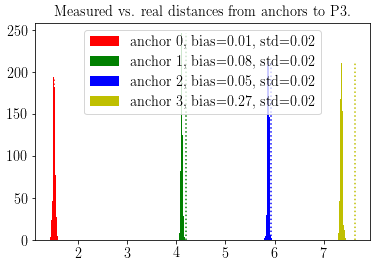

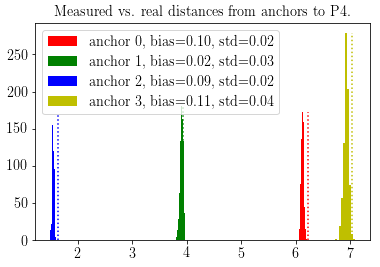

In [73]:
path = 'data/Static/'
anchors_full = np.genfromtxt(path+'anchors_EPFL.csv', delimiter=',')
anchors = anchors_full[:,1:]
real_full = np.genfromtxt(path+'data_EPFL.csv', delimiter=',')
real = real_full[:,1:]
n_positions = 5
N = anchors.shape[0]+1 

distances_all_points = []

colors = ['r','g','b','y','c']
for i in range(n_positions):
    data = np.genfromtxt(path+'pozyx_data_P{}.csv'.format(i), delimiter=',')
    P_i = real[i,:]
    id_i = int(real_full[i,0])
    
    idx_i = data[:,1] == id_i
    # Get samples corresponding to all pairs.
    distances_per_point  = []
    
    fig = plt.figure()
    #fig.set_fig(20)
    for j,a in enumerate(anchors_full):
        axs = fig.add_subplot(1,1,1)
        #axs = fig.add_subplot(1,len(anchors_full),j+1)
        P_a = a[1:]
        id_a = int(a[0])
        idx_a = data[:,2] == id_a 
        distance_real = np.linalg.norm(P_a - P_i)
        distances_ia = data[idx_a & idx_i, -1]
        
        bias = abs(distance_real - np.mean(distances_ia))
        std = np.std(distances_ia)
        
        distances_per_point.append(distances_ia)
        vals, bins, __ = axs.hist(distances_ia, label='anchor {}, bias={:2.2f}, std={:2.2f}'.format(j,bias,std),color=colors[j])
        ymax = max(vals)
        axs.vlines(distance_real, 0, ymax,color=colors[j], linestyle=':')
        plt.legend(loc='best')
    plt.title('Measured vs. real distances from anchors to P{}.'.format(i))
    plt.show()
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #bp = ax.boxplot(distances_per_point)
    #ax.set_xlabel('Anchor Id')
    #ax.set_ylabel('Distance [m]')
    #ax.set_xticklabels(anchors_full[:,0].astype('int').astype('str'))
    #ax.set_title('Point {}: {}, id={}'.format(i,P_i,id_i))
    #plt.show()
    distances_all_points.append(distances_per_point)

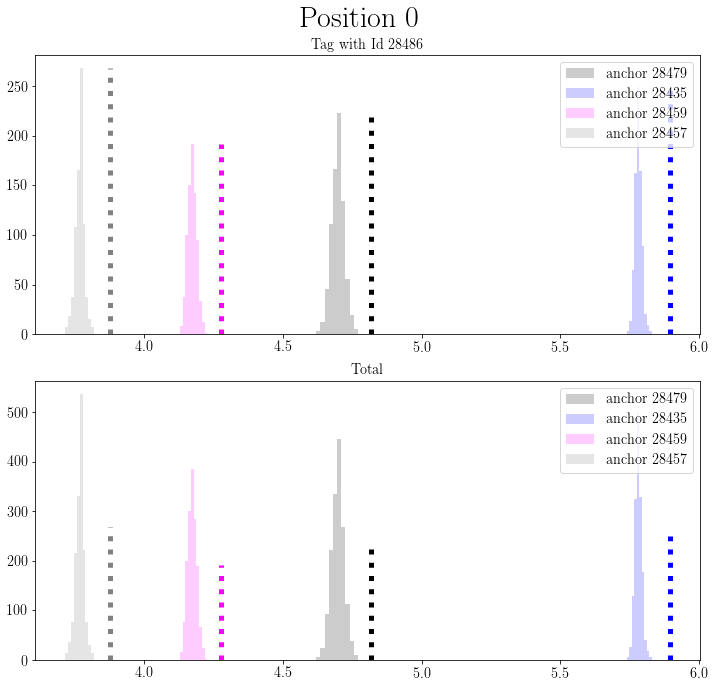

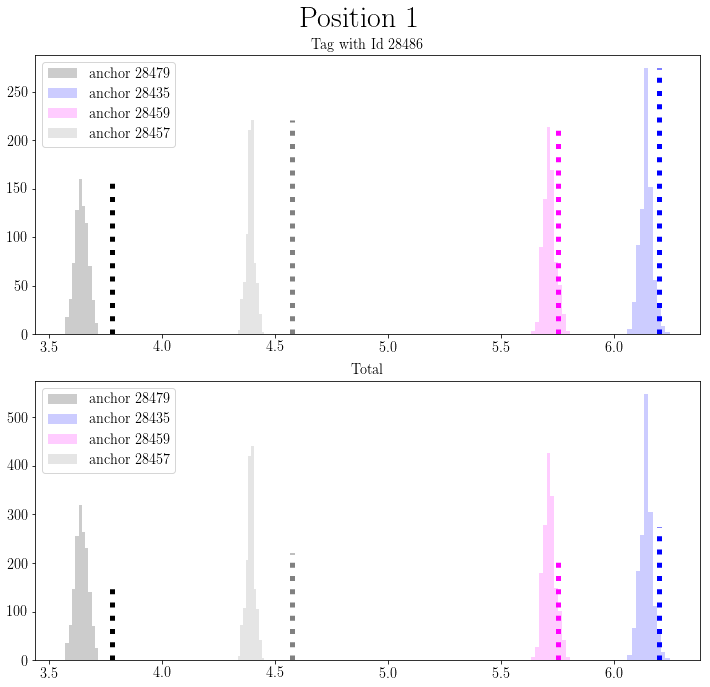

In [74]:
import plots_cti as plots
from experiments import read_experimental_data
from experiments import N_POSITIONS

april_tag_id = 333
pozyx_tag_id = 28486

# Pozyx
path = 'data/Pozyx/Static/'
name = 'pozyx_data_P{}.csv'
runs = [0]
tag_ids = [pozyx_tag_id]
weighted = False

# Ubiment
#path = 'data/Ubiment/Static/'
#name = 'data_P{}_{}.csv'
#runs = [1,2]
#tag_ids = [april_tag_id, pozyx_tag_id]
#weighted = True

results, anchors = read_experimental_data(path, name, runs, tag_ids, weighted)

## Compare weights (Ubiment only)

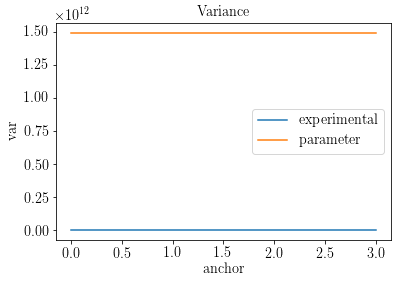

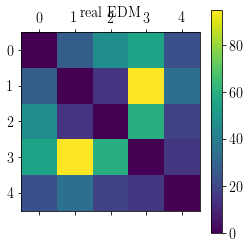

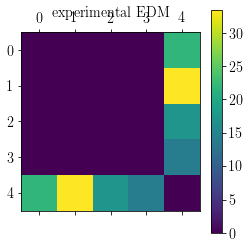

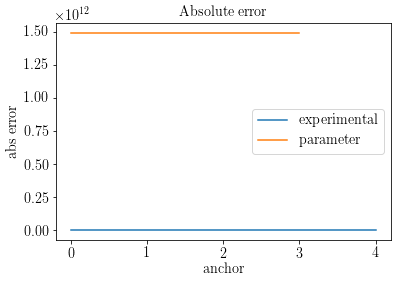

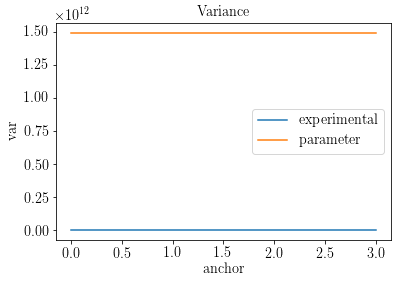

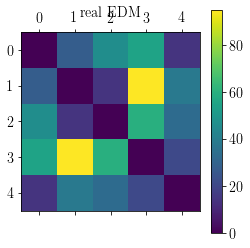

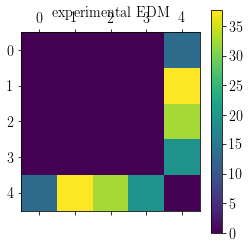

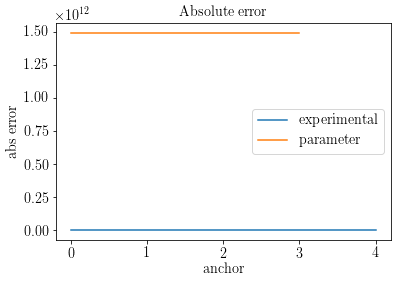

In [63]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm, create_from_points, edm_from_dm
from plots_cti import plot_matrix
index = -1
for result in results:
    var_exp = [np.var(d) for d in result.distances]
    var = np.delete(result.var_avg[index,:],index)
    plt.plot(var_exp, label='experimental')
    plt.plot(var, label='parameter')
    plt.title('Variance')
    plt.xlabel('anchor')
    plt.ylabel('var')
    plt.legend(loc='best')
    plt.show()
    
    real_points = np.r_[anchors,result.real.reshape((1,-1))]
    porig = create_from_points(real_points, HeterogenousConfiguration)
    abs_error_exp = np.abs(result.edm_avg[index,:] - porig.edm[index,:])
    abs_error = np.delete(result.abs_error_avg[index,:],index)
    
    plot_matrix(porig.edm, 'real EDM')
    plot_matrix(result.edm_avg,'experimental EDM')
    
    plt.plot(abs_error_exp, label='experimental')
    plt.plot(abs_error, label='parameter')
    plt.title('Absolute error')
    plt.xlabel('anchor')
    plt.ylabel('abs error')
    plt.legend(loc='best')
    plt.show()

## Apply algorithms

In [68]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm, create_from_points, edm_from_dm
from algorithms import reconstruct_mds, reconstruct_srls, reconstruct_weighted
from plots_cti import plot_matrix
    
points_mds = []
points_mds_weighted = []
points_srls = []
points_srls_weighted = []
points_original = []

printout=False

for result in results:
    N = result.edm_avg.shape[0]
    real_points = np.r_[anchors,result.real.reshape((1,-1))]
    porig = create_from_points(real_points, HeterogenousConfiguration)
    index = N-1
    other = np.delete(np.arange(N),index)
    
    dist = [np.mean(d) for d in result.distances]
    r2 = np.power(dist,2)
    
    edm = result.edm_avg
    pnoisy = porig.copy()
    pnoisy.edm[edm>0] = edm[edm>0]
    
    # Add weights based on bias
    #weights = np.abs(porig.edm[-1,:-1] - r2)
    #print('weights:',weights)
    
    # Add weights based on sigma
    #weights = [np.power(np.std(d),-2) for d in result.distances]  
    #weights /= sum(weights)
    
    #weights_matrix = np.ones((N,N))*max(weights)
    #weights_matrix[index,other] = weights
    #weights_matrix[other,index] = weights
    
    # Add LOESS weights
    max_dik = np.max(pnoisy.edm,axis=1)**(0.5)
    max_dkj = np.max(pnoisy.edm,axis=0)**(0.5)
    weights_matrix = np.ones((N,N))
    for i in range(N):
        for j in range(N):
            hij = max(max_dik[i],max_dkj[j])
            weights_matrix[i,j] = np.exp(-pnoisy.edm[i,j]/hij**2)
    #plot_matrix(weights_matrix)
    
    Xmds = reconstruct_mds(pnoisy.edm, porig.points, False, 'geometric')
    Xmds_weighted, fs, err_edms, err_points = reconstruct_weighted(pnoisy.edm, weights_matrix, porig.points, Xmds, porig.points, False)
    Xsrls = reconstruct_srls(pnoisy.edm, porig.points, False, index)
    Xsrls_weighted = reconstruct_srls(pnoisy.edm, porig.points, False, weights=weights_matrix)
    
    pmds = create_from_points(Xmds, PointConfiguration)
    pmds_weighted = create_from_points(Xmds_weighted, PointConfiguration)
    psrls = create_from_points(Xsrls, PointConfiguration)
    psrls_weighted = create_from_points(Xsrls_weighted, PointConfiguration)
    if (printout):
        print('Noisy edm error',np.linalg.norm(pnoisy.edm-porig.edm))
        print('SRLS edm error',np.linalg.norm(psrls.edm-porig.edm))
        print('MDS edm error ',np.linalg.norm(pmds.edm-porig.edm))
        plt.matshow(porig.edm-psrls.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff SRLS {}'.format(i))
        plt.show()
        plt.matshow(porig.edm-pmds.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff MDS {}'.format(i))
        plt.show()
    
    points_original.append(porig.points)
    points_mds.append(Xmds)
    points_mds_weighted.append(Xmds_weighted)
    points_srls.append(Xsrls)
    points_srls_weighted.append(Xsrls_weighted.copy())

## 2D Visualization

rmse mds 0.1761440226273985
rmse mds weighted 0.12300836592952234
rmse srls 0.20281433046424427
rmse srls weighted 0.20155006730047287


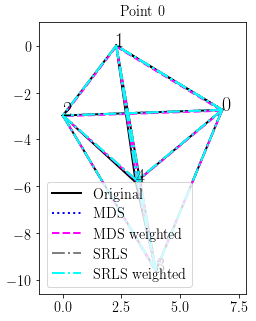

rmse mds 0.2317063137969956
rmse mds weighted 0.04693505479053704
rmse srls 0.22745680767079132
rmse srls weighted 0.22863866127670587


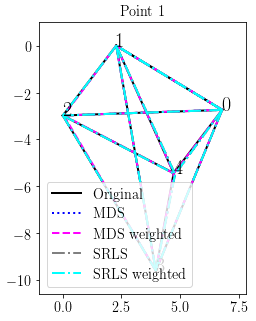

In [69]:
from plots_cti import plot_point_sets
from basics import rmse

n_methods = 4
names=['Original','MDS','MDS weighted','SRLS','SRLS weighted']
rmses = np.zeros((n_methods, N_POSITIONS))
size = [5,5]
for i in range(N_POSITIONS):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls = points_srls[i]
    Xsrls_weighted = points_srls_weighted[i]
    rmse_mds = rmse(Xmds[-1,:], Xorig[-1,:])
    rmse_srls = rmse(Xsrls[-1,:], Xorig[-1,:])
    rmse_srls_weighted = rmse(Xsrls_weighted[-1,:], Xorig[-1,:])
    rmse_mds_weighted = rmse(Xmds_weighted[-1,:], Xorig[-1,:])
    
    rmses[:,i] = [rmse_mds, rmse_mds_weighted, rmse_srls, rmse_srls_weighted]
    print('rmse mds', rmse_mds)
    print('rmse mds weighted', rmse_mds_weighted)
    print('rmse srls', rmse_srls)
    print('rmse srls weighted', rmse_srls_weighted)
    
    plot_point_sets([Xorig,Xmds,Xmds_weighted,Xsrls,Xsrls_weighted],'Point {}'.format(i),size=size,names=names)
    #plot_points(Xsrls, title='SRLS, rmse={:2.2e}'.format(rmse_slrs), size=size)
    #plot_points(Xmds, title='MDS, rmse={:2.2e}'.format(rmse_mds),size=size)
    

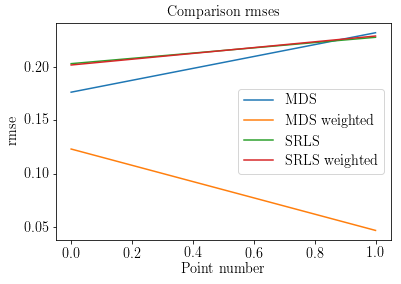

In [70]:
for i,method in enumerate(rmses):
    plt.plot(method,label=names[i+1])
plt.legend(loc='best')
plt.xlabel('Point number')
plt.ylabel('rmse')
plt.title('Comparison rmses')
plt.show()

## 3D Visualization

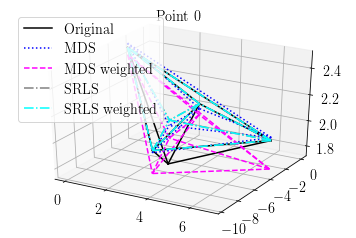

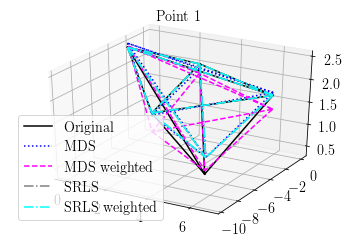

In [71]:
from plots_cti import plot_point_sets_3d

for i in range(N_POSITIONS):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xsrls = points_srls[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls_weighted = points_srls_weighted[i]
    plot_points = [Xorig, Xmds, Xmds_weighted, Xsrls, Xsrls_weighted]
    plot_point_sets_3d(plot_points, names, 'Point {}'.format(i))